In [1]:
from typing import Callable
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# QPE implementation

GPU: https://pennylane.ai/install#high-performance-computing-and-gpus

In [38]:
num_shots = None
dev = qml.device("default.qubit", shots = 1024) # no shots means analytical calculation
#dev = qml.device("lightning.gpu", wires=num_qubits)

In [ ]:
@qml.qnode(dev)
def circuit_qpe(
    estimation_wires: list[int],
    q_register: list[int],
    state_prep: Callable[[list[int]], None],
    controlled_unitary: Callable[..., None],
    **kargs
):
    """
    Quantum Phase Estimation (QPE) circuit.

    Args:
        estimation_wires: List of qubits used to estimate the phase.
        q_register: List of qubits holding the eigenstate of the unitary.
        state_prep: Function that prepares the initial state |u⟩ on q_register.
        controlled_unitary: Function that applies controlled-U^{2^i}.
        **kargs: Additional arguments passed to controlled_unitary.

    Returns:
        Probability distribution over estimation_wires after QPE.
    """
    # initial state
    state_prep(q_register)

    for wire in estimation_wires:
        qml.Hadamard(wires=wire)

    for i, control in enumerate(reversed(estimation_wires)):
        controlled_unitary(control, q_register, 2**i, **kargs)

    qml.adjoint(qml.QFT)(wires=estimation_wires)

    return qml.probs(wires=estimation_wires)

In [40]:
def binary_string_to_decimal(binary_string: str) -> float:
    # binary_string represent the bits of the decimal number in format 0.i_1i_2...i_n
    # where binary_string is i_1i_2...i_n
    res = 0
    for i, bit in enumerate(binary_string):
        res += float(bit)*2**(-i-1)
        
    return res

### Example

Computing the phase $\theta$ for $e^{i2\pi/5}$, which is the eigenvalue of 

$U = \begin{bmatrix}
1 & 0 \\
0 & e^{i2\pi/5}
\end{bmatrix}$

corresponding to the eigenvector $|1\rangle$. The output should be $\theta = 1/5$.

In [41]:
num_digits = 6

results = circuit_qpe(
    estimation_wires=range(num_digits),
    q_register = [num_digits],
    state_prep = lambda wires: qml.X(wires[0]),
    controlled_unitary = lambda control, q_register, k: qml.ControlledPhaseShift(2*k * np.pi / 5, wires=[control]+q_register)
)

results_ordered = [(f"0.{x:0{num_digits}b}", results[x]) for x in range(len(results))]
results_ordered.sort(key=lambda tup: tup[1], reverse=True)

print(results_ordered[0])
print(binary_string_to_decimal(results_ordered[0][0][2:]))

('0.001101', np.float64(0.8779296875))
0.203125


Notice the result is $\approx 0.2 = 1/5$.

# Application: Ground state energy for Hydrogen molecule (H2)

## Hamiltonian for H2

Reference: https://dojo.qulacs.org/en/latest/notebooks/7.1_quantum_phase_estimation_detailed.html#Example:-Calculation-of-the-ground-state-energy-of-the-hydrogen-molecular-Hamiltonian-using-the-quantum-phase-estimation-algorithm

The Hamiltonian of the Hydrogen molecule is written in the second quantized, expressed in terms of creation and annihilation operators acting on some basis of molecular orbitals. Then, using Bravyi-Kitaev transformation, this Hamiltonian is mapped into qubits using the minimial STO-6G basis, getting the 4-qubit Hamiltonian
$$
H = f_0 I + f_1Z_0 + f_2 Z_1 + f_3Z_2 + f_1Z_0Z_1 \\
+ f_4Z_0Z_2 + f_5Z_1Z_3 + f_6X_0Z_1X_2 + f_6Y_0Z_1Y_2 \\
+ f_7Z_0Z_1Z_2 + f_4Z_0Z_2Z_3 + f_3 Z_1Z_2Z_3 \\
+ f_6 X_0 Z_1 X_2 Z_3 + f_6 Y_0 Z_1 Y_2 Z_3 + f_7Z_0Z_1Z_2Z_3,
$$
where the values $f_i$ depend on the fixed bond length of the molecule. Noticing this Hamiltonian stabilizes qubits 1 and 3 when they start in $|0\rangle$ (as in Hartree-Fock state), we can obtain a reduced two-qubit Hamiltonian:
$$
H = \sum_{i} g_i H_i = g_0I + g_1Z_0 + g_2Z_1 + g_3Z_0Z_1 + g_4Y_0Y_1 + g_5X_0X_1,
$$
where the $g_i$ values are function of the $f_i$ values.

We need to decompose $U=e^{-i\tau H}$ into a quantum circuit, where $\tau$ is a constant such that $[E_{\text{min}}, E_{\text{max}}]$ is shrinked to $[0, 2\pi]$. Since $g_0I$ and $g_3Z_0Z_1$ conmute with the other terms:
$$
e^{-i\tau H} = \exp(-i\tau \sum_{i} g_i H_i) = \exp[-i\tau g_0I]\exp[-i\tau g_3Z_0Z_1]\exp[-i\tau H_{eff}],
$$
$$
H_{eff}:= g_1Z_0 + g_2Z_1+ g_4Y_0Y_1 + g_5X_0X_1.
$$
Use Trotterization:
$$
U_{eff}:=\exp[-i\tau H_{eff}] \approx \left(\prod_{i=1,2,4, 5}\exp[-i\tau H_i/N ]\right)^N.
$$
The exponentials in the right-hand side are of the form $\exp(i\theta P)$, where $P$ is a Pauli matrix, and it is easy to implement it in a quantum circuit.

### Finding eigenvalues of $H$ and $H_{\text{eff}}$ classically

In [3]:
def construct_H_eff(coeff: list[float]) -> np.ndarray:
    c1, c2, c3, c4 = coeff

    # Pauli matrices and the identity matrix
    X = np.array([[0, 1], [1, 0]], dtype=complex)
    Y = np.array([[0, -1j], [1j, 0]], dtype=complex)
    Z = np.array([[1, 0], [0, -1]], dtype=complex)
    I = np.eye(2, dtype=complex)

    # c1 * Z_0
    term1 = c1 * np.kron(Z, I)

    # c2 * Z_1 
    term2 = c2 * np.kron(I, Z)

    # c3 * Y_0 Y_1
    term3 = c3 * np.kron(Y, Y)

    # c4 * X_0 X_1
    term4 = c4 * np.kron(X, X)

    return term1 + term2 + term3 + term4



def construct_hamiltonian(coeff: list[float]) -> np.ndarray:
    g0, g1, g2, g3, g4, g5 = coeff
    
    # Pauli matrix Z
    Z = np.array([[1, 0], [0, -1]], dtype=complex)

    # g0 * I
    term1 = g0 * np.eye(4, dtype=complex)
    
    # g3 * Z_0 Z_1
    term2 = g3 * np.kron(Z, Z)
    
    # H_eff
    H_eff = construct_H_eff([g1, g2, g4, g5])

    return term1 + term2 + H_eff

Table of coefficientes for different internuclear distance

In [15]:
coeffs_df = pd.read_csv("table_coeffs.csv")
coeffs_df.head()

,nuclear_dist,I,Z0,Z1,Z0Z1,X0X1,Y0Y1,t0,ordering,trotter_error
0,0.20,2.8489,0.5678,-1.4508,0.6799,0.0791,0.0791,1.50,Z0·X0X1·Z1·Y0Y1,0.0124
1,0.25,2.1868,0.5449,-1.2870,0.6719,0.0798,0.0798,1.59,Z0·Y0Y1·Z1·X0X1,0.0521
2,0.30,1.7252,0.5215,-1.1458,0.6631,0.0806,0.0806,1.77,X0X1·Z0·Y0Y1·Z1,0.0111
3,0.35,1.3827,0.4982,-1.0226,0.6537,0.0815,0.0815,2.08,Z0·X0X1·Z1·Y0Y1,0.0368
4,0.40,-0.2047,0.4754,-0.9145,0.6438,0.0825,0.0825,2.10,Z0·X0X1·Z1·Y0Y1,0.0088


Computing the ground state energy for internuclear distance $R=0.70$

In [22]:
coeffs_eg = coeffs_df.loc[10]
coeffs_eg

nuclear_dist                 0.7
I                        -0.4584
Z0                        0.3593
Z1                       -0.4826
Z0Z1                      0.5818
X0X1                      0.0896
Y0Y1                      0.0896
t0                          0.64
ordering         Z0·Y0Y1·Z1·X0X1
trotter_error             0.0171
Name: 10, dtype: object

In [45]:
H_eff = construct_H_eff(coeffs_eg[["Z0", "Z1", "Y0Y1", "X0X1"]])
H = construct_hamiltonian(coeffs_eg[["I", "Z0", "Z1", "Z0Z1", "Y0Y1", "X0X1"]])

In [46]:
eigs_H = np.linalg.eigvals(H)
eigs_H_eff = np.linalg.eigvals(H_eff)

print("H")
print("Eigenvalues:", eigs_H)
print("Minimum:", np.min(eigs_H))
print("-"*10)
print("H_eff")
print("Eigenvalues:", eigs_H_eff)
print("Minimum:", np.min(eigs_H_eff))

H
Eigenvalues: [-1.90096027e+00+0.j -1.79439726e-01+0.j  1.00000000e-04+0.j
  2.46700000e-01+0.j]
Minimum: (-1.900960274408618+0j)
----------
H_eff
Eigenvalues: [-0.86076027+0.j  0.86076027+0.j -0.1233    +0.j  0.1233    +0.j]
Minimum: (-0.8607602744086181+0j)


### Computing the exact energy surface

In [64]:
energy_surface = np.zeros(len(coeffs_df))
for idx, coeffs in coeffs_df.iterrows():
    hamiltonian = construct_hamiltonian(coeffs[["I", "Z0", "Z1", "Z0Z1", "Y0Y1", "X0X1"]]) # construct_H_eff(coeffs[["Z0", "Z1", "Y0Y1", "X0X1"]]) 
    eigs_H = np.linalg.eigvals(hamiltonian)
    energy_surface[idx] = np.min(eigs_H).real

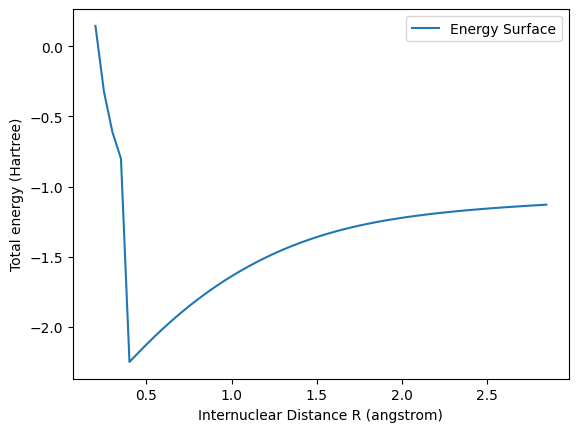

In [70]:
plt.plot(coeffs_df["nuclear_dist"], energy_surface, label="Energy Surface")
plt.xlabel("Internuclear Distance R (angstrom)")
plt.ylabel("Total energy (Hartree)")
plt.legend()
plt.show()

### Finding eigenvalues of $H$ and $H_{\text{eff}}$ with Quantum Phase Estimation algorithm

### Initial state with sufficient overlap with the ground state

It turns out that the Hartree-Fock state is $|01\rangle$.

In [37]:
coeffs_eg

nuclear_dist                 0.7
I                        -0.4584
Z0                        0.3593
Z1                       -0.4826
Z0Z1                      0.5818
X0X1                      0.0896
Y0Y1                      0.0896
t0                          0.64
ordering         Z0·Y0Y1·Z1·X0X1
trotter_error             0.0171
Name: 10, dtype: object

In [28]:
tau = coeffs_eg["t0"]
coeff = coeffs_eg[["I", "Z0", "Z1", "Z0Z1", "X0X1", "Y0Y1"]]

Function that computes the controlled $U^{2^j}$ gates for the QPE circuit.

In [29]:
def controlledHydrogenUnitary(
    control: int,
    target_wires: list[int],
    k: int,
    tau: float,
    trotter_steps: int,
    coeff: list[float],
):
    """Apply the controlled-exp(-i*tau*k*H), where H is explained above"""

    # we may omit exp(-i*tau*g_0 I) and add tau*g_0 to the eigenvalue obtained
    g0, g1, g2, g3, g4, g5 = coeff

    # controlled-RZZ
    # qml.CNOT(wires=[target_wires[0], target_wires[1]])
    # qml.CRZ(phi=2 * g3 * tau * k / trotter_steps, wires=[control, target_wires[1]])
    # qml.CNOT(wires=[target_wires[0], target_wires[1]])

    # trotterization for U_eff^k
    for _ in range(trotter_steps):
        
        # controlled-RZ0
        qml.CRZ(phi=2 * g1 * tau * k / trotter_steps, wires=[control, target_wires[0]])
        
        # controlled-RYY
        qml.adjoint(qml.S)(wires=target_wires[0])
        qml.adjoint(qml.S)(wires=target_wires[1])
        qml.Hadamard(wires=target_wires[0])
        qml.Hadamard(wires=target_wires[1])
        qml.CNOT(wires=[target_wires[0], target_wires[1]])
        qml.CRZ(phi=2 * g4 * tau * k / trotter_steps, wires=[control, target_wires[1]])
        qml.CNOT(wires=[target_wires[0], target_wires[1]])
        qml.Hadamard(wires=target_wires[0])
        qml.Hadamard(wires=target_wires[1])
        qml.S(wires=target_wires[0])
        qml.S(wires=target_wires[1])
        
        # controlled-RZ1
        qml.CRZ(phi=2 * g2 * tau * k / trotter_steps, wires=[control, target_wires[1]])
        
        # controlled-RXX
        qml.Hadamard(wires=target_wires[0])
        qml.Hadamard(wires=target_wires[1])
        qml.CNOT(wires=[target_wires[0], target_wires[1]])
        qml.CRZ(phi=2 * g5 * tau * k / trotter_steps, wires=[control, target_wires[1]])
        qml.CNOT(wires=[target_wires[0], target_wires[1]])
        qml.Hadamard(wires=target_wires[0])
        qml.Hadamard(wires=target_wires[1])

In [30]:
eigs1 = []
eigs2 = []

#trotter_steps = 5
num_digits = 11

for trotter_steps in range(1, 12):
    results = circuit_qpe(
        estimation_wires=range(num_digits),
        q_register = [num_digits, num_digits+1],
        state_prep = lambda wires: qml.X(wires[0]),
        controlled_unitary = controlledHydrogenUnitary,
        tau = tau,
        trotter_steps = trotter_steps,
        coeff = coeff,
    )
    
    results_ordered = [(f"0.{x:0{num_digits}b}", results[x]) for x in range(len(results))]
    results_ordered.sort(key=lambda tup: tup[1], reverse=True)
    
    phase_1 = binary_string_to_decimal(results_ordered[0][0][2:])
    phase_2 = binary_string_to_decimal(results_ordered[1][0][2:])
    
    result_1 = -2*np.pi*phase_1/tau
    result_2 = -2*np.pi*phase_2/tau
        
    print("Trotter steps:", trotter_steps)
    print(f"1 result ({results_ordered[0][0]}): {result_1:.4f} ", f"- probability: {results_ordered[0][1]:.4f} - phase: {phase_1:.4f}")
    print(f"2 result ({results_ordered[1][0]}): {result_2:.4f}", f"- probability: {results_ordered[1][1]:.4f} - phase: {phase_1:.4f}")
    print("\n")
    
    eigs1.append(result_1)
    eigs2.append(result_2)

Trotter steps: 1
1 result (0.00010010001): -0.6951  - probability: 0.0709 - phase: 0.0708
2 result (0.00010010000): -0.6903 - probability: 0.0516 - phase: 0.0708


Trotter steps: 2
1 result (0.00010100110): -0.7958  - probability: 0.1447 - phase: 0.0811
2 result (0.00010100010): -0.7766 - probability: 0.1165 - phase: 0.0811


Trotter steps: 3
1 result (0.00010101101): -0.8293  - probability: 0.0564 - phase: 0.0845
2 result (0.00010101100): -0.8245 - probability: 0.0558 - phase: 0.0845


Trotter steps: 4
1 result (0.00010101010): -0.8149  - probability: 0.3367 - phase: 0.0830
2 result (0.00010100110): -0.7958 - probability: 0.1557 - phase: 0.0830


Trotter steps: 5
1 result (0.00011000000): -0.9204  - probability: 0.2059 - phase: 0.0938
2 result (0.00010100000): -0.7670 - probability: 0.1398 - phase: 0.0938


Trotter steps: 6
1 result (0.00010100110): -0.7958  - probability: 0.1570 - phase: 0.0811
2 result (0.00010110110): -0.8725 - probability: 0.1115 - phase: 0.0811


Trotter steps: 7

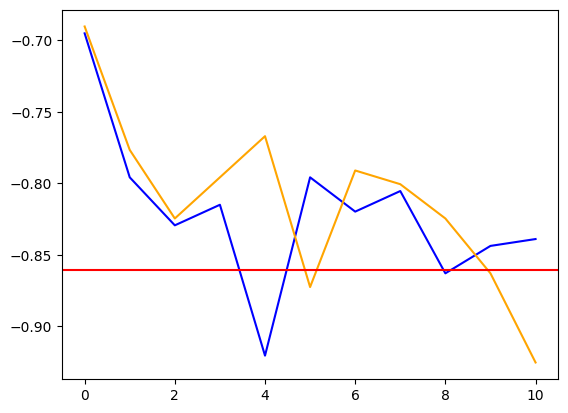

In [31]:
exact_eig = -0.8607602744
plt.plot(eigs1, color="blue")
plt.plot(eigs2, color="orange")
plt.axhline(y=exact_eig, color='r', linestyle='-')

In [32]:
results = circuit_qpe(
    estimation_wires=range(11),
    q_register = [11, 12],
    state_prep = lambda wires: qml.X(wires[1]),
    controlled_unitary = controlledHydrogenUnitary,
    tau = tau,
    trotter_steps = trotter_steps,
    coeff = coeff,
)

In [33]:
results

array([1.75438382e-05, 1.29664976e-04, 2.03185328e-04, ...,
       3.50412558e-04, 4.13310928e-04, 3.76262748e-04])

In [112]:
cumsum = np.cumsum([tup[1] for tup in results_ordered])
for i, s in enumerate(cumsum):
    if s >= 0.9:
        cumsum_i = i
        print(i)
        break

93


In [113]:
results_ordered = results_ordered[:cumsum_i + 1]
results_ordered.sort(key=lambda tup: tup[0])

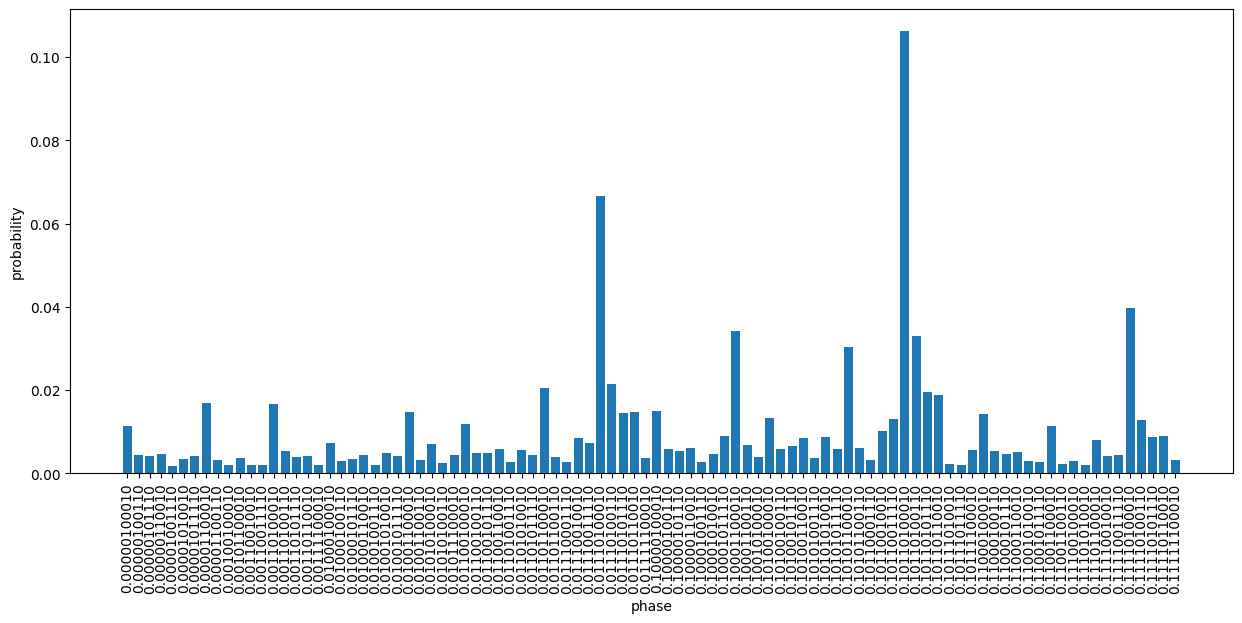

In [114]:
plt.figure(figsize=(15, 8))
plt.bar([tup[0] for tup in results_ordered], [tup[1] for tup in results_ordered])
plt.xlabel("phase")
plt.ylabel("probability")
plt.xticks(rotation="vertical")
plt.subplots_adjust(bottom=0.3)

In [115]:
max_i = np.argmax([tup[1] for tup in results_ordered])
max_i

np.int64(69)

In [116]:
results_ordered[max_i]

('0.10110100010', np.float64(0.10619373096465003))

In [117]:
res = 0
for i, bit in enumerate(results_ordered[max_i][0][2:]):
    res += float(bit)*2**(-i-1)
    
print(res)

0.7041015625


In [118]:
- res/tau

-1.10015869140625

## Relation between the 4-qubit Hamiltonian and the 2-qubit Hamiltonian

Verification that the minimum eigenvalue of the 4-qubit Hamiltonian is the same as the 2-qubit Hamiltonian (in progress)

In [ ]:
def kron4(a: np.ndarray, b: np.ndarray, c: np.ndarray, d: np.ndarray) -> np.ndarray:
    # Tensor product of four matrices
    return np.kron(np.kron(np.kron(a, b), c), d)

def construct_H_complete(coeff: list[float]) -> np.ndarray:
    # Pauli matrices and the identity matrix
    X = np.array([[0, 1], [1, 0]], dtype=complex)
    Y = np.array([[0, -1j], [1j, 0]], dtype=complex)
    Z = np.array([[1, 0], [0, -1]], dtype=complex)
    I = np.eye(2, dtype=complex)
    
    H = np.zeros((16, 16), dtype=complex)
    
    H += coeff[0] * kron4(I, I, I, I)
    H += coeff[1] * kron4(Z, I, I, I)
    H += coeff[2] * kron4(I, Z, I, I)
    H += coeff[3] * kron4(I, I, Z, I)
    H += coeff[1] * kron4(Z, Z, I, I)
    H += coeff[4] * kron4(Z, I, Z, I)
    H += coeff[5] * kron4(I, Z, I, Z)
    H += coeff[6] * kron4(X, Z, X, I)
    H += coeff[6] * kron4(Y, Z, Y, I)
    H += coeff[7] * kron4(Z, Z, Z, I)
    H += coeff[4] * kron4(Z, I, Z, Z)
    H += coeff[3] * kron4(I, Z, Z, Z)
    H += coeff[6] * kron4(X, Z, X, Z)
    H += coeff[6] * kron4(Y, Z, Y, Z)
    H += coeff[7] * kron4(Z, Z, Z, Z)
    
    return H

In [ ]:
coeff_fs = [
    -0.81261, 0.171201, 0.16862325, -0.2227965, 0.171201,
    0.12054625, 0.17434925, 0.04532175, 0.04532175, 
    0.165868, 0.12054625, -0.2227965, 
    0.04532175, 0.04532175, 0.165868
    ]
coeff_gs = np.zeros(6)

coeff_gs[0] = coeff_fs[0] + coeff_fs[2] + coeff_fs[5]
coeff_gs[1] = 2*coeff_fs[1] + coeff_fs[4]
coeff_gs[2] = 2*coeff_fs[3]
coeff_gs[3] = 2*(coeff_fs[4] + coeff_fs[7])
coeff_gs[4] = 2*coeff_fs[6]
coeff_gs[5] = 2*coeff_fs[6]
coeff_gs

array([-0.5234405,  0.513603 , -0.445593 ,  0.4330455,  0.3486985,
        0.3486985])

In [ ]:
coeff_fs = np.random.rand(8)
coeff_gs = np.zeros(6)

coeff_gs[0] = coeff_fs[0] + coeff_fs[2] + coeff_fs[5]
coeff_gs[1] = 2*coeff_fs[1] + coeff_fs[4]
coeff_gs[2] = 2*coeff_fs[3]
coeff_gs[3] = 2*(coeff_fs[4] + coeff_fs[7])
coeff_gs[4] = 2*coeff_fs[6]
coeff_gs[5] = 2*coeff_fs[6]

In [ ]:
H_complete = construct_H_complete(coeff_fs)
H_reduced = construct_hamiltonian(coeff_gs)

In [ ]:
eigvals_H_reduced = np.linalg.eigvals(H_reduced)
eigvals_H_complete = np.linalg.eigvals(H_complete)

print("Eigenvalues of 2-qubit Hamiltonian:", eigvals_H_reduced)
print("Eigenvalues of 4-qubit Hamiltonian:", eigvals_H_complete)

Eigenvalues of 2-qubit Hamiltonian: [-2.14241161+0.j  0.22943961+0.j -0.022385  +0.j -0.158405  +0.j]
Eigenvalues of 4-qubit Hamiltonian: [-0.656141  -2.46519033e-32j -2.050935  +6.16297582e-33j
  0.09579661+0.00000000e+00j -2.00876861+0.00000000e+00j
 -0.193586  +0.00000000e+00j -0.422131  +0.00000000e+00j
 -0.422131  +0.00000000e+00j -0.850021  +0.00000000e+00j
 -1.30628   +0.00000000e+00j -0.415094  +0.00000000e+00j
 -1.106935  +0.00000000e+00j  0.012796  +0.00000000e+00j
 -1.106935  +0.00000000e+00j -1.30628   +0.00000000e+00j
 -0.850021  +0.00000000e+00j -0.415094  +0.00000000e+00j]


In [ ]:
min(eigvals_H_reduced), min(eigvals_H_complete)

(np.complex128(-2.1424116056030673+0j),
 np.complex128(-2.050935+6.162975822039155e-33j))